In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import losses

from sklearn.metrics import classification_report
from collections import defaultdict

from utils.data_loader import create_dataset
from utils.model_loss import TverskyBCEPerSequence
from utils.model_inference_plots import *

In [2]:
df = pd.read_parquet('data/v80/final_model_data_tha_scaled.parquet')

In [3]:
X = df[['Bx', 'By', 'Bz', 'Bx_lag_1', 'Bx_lag_2', 'By_lag_1',
        'By_lag_2', 'Bz_lag_1', 'Bz_lag_2', 'Bx_conditional_vol',
        'By_conditional_vol', 'Bz_conditional_vol', 'Bx_rolling_stdev',
        'By_rolling_stdev', 'Bz_rolling_stdev']].values

y = df['Event_label_80'].values

In [ ]:
total_samples = len(X)
n_features = X.shape[1]

train_size = int(0.6 * total_samples)
test_size = total_samples - train_size

In [ ]:
# Batch size for the model, n_timesteps is the number of timesteps in each sequence
# 500 corresponds to ~25 minutes of data which is the average event duration
# The stride of 40 reduces redundancy between sequences and speeds up training times
batch_size = 256
n_timesteps = 500
stride = 40

train_idx = (0, train_size)
test_idx = (train_size, total_samples)

# Creates the test dataset for model inference
test_dataset = create_dataset(X, y, n_timesteps, batch_size, stride, test_idx[0], test_idx[1])

In [ ]:
# Define number of steps to run model for
steps_test_epoch = int(np.ceil((test_size - n_timesteps) / (stride * batch_size)))

In [ ]:
# Load the model with custom loss object
model = keras.models.load_model(
    "models/mosrl_80_2_customf3_model.keras",
    custom_objects={"tversky_bce_per_sequence": TverskyBCEPerSequence}
)

In [ ]:
# Gets the first batch in the test set
test_iter = iter(test_dataset)
X_sample, y_sample = next(test_iter)

In [ ]:
# Predict model on sample of test set to extract attention weights of the model
attention_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('multi_head_attention').output)
attention_output, attention_weights = attention_model.predict(X_sample)

2025-05-01 16:35:13.097154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


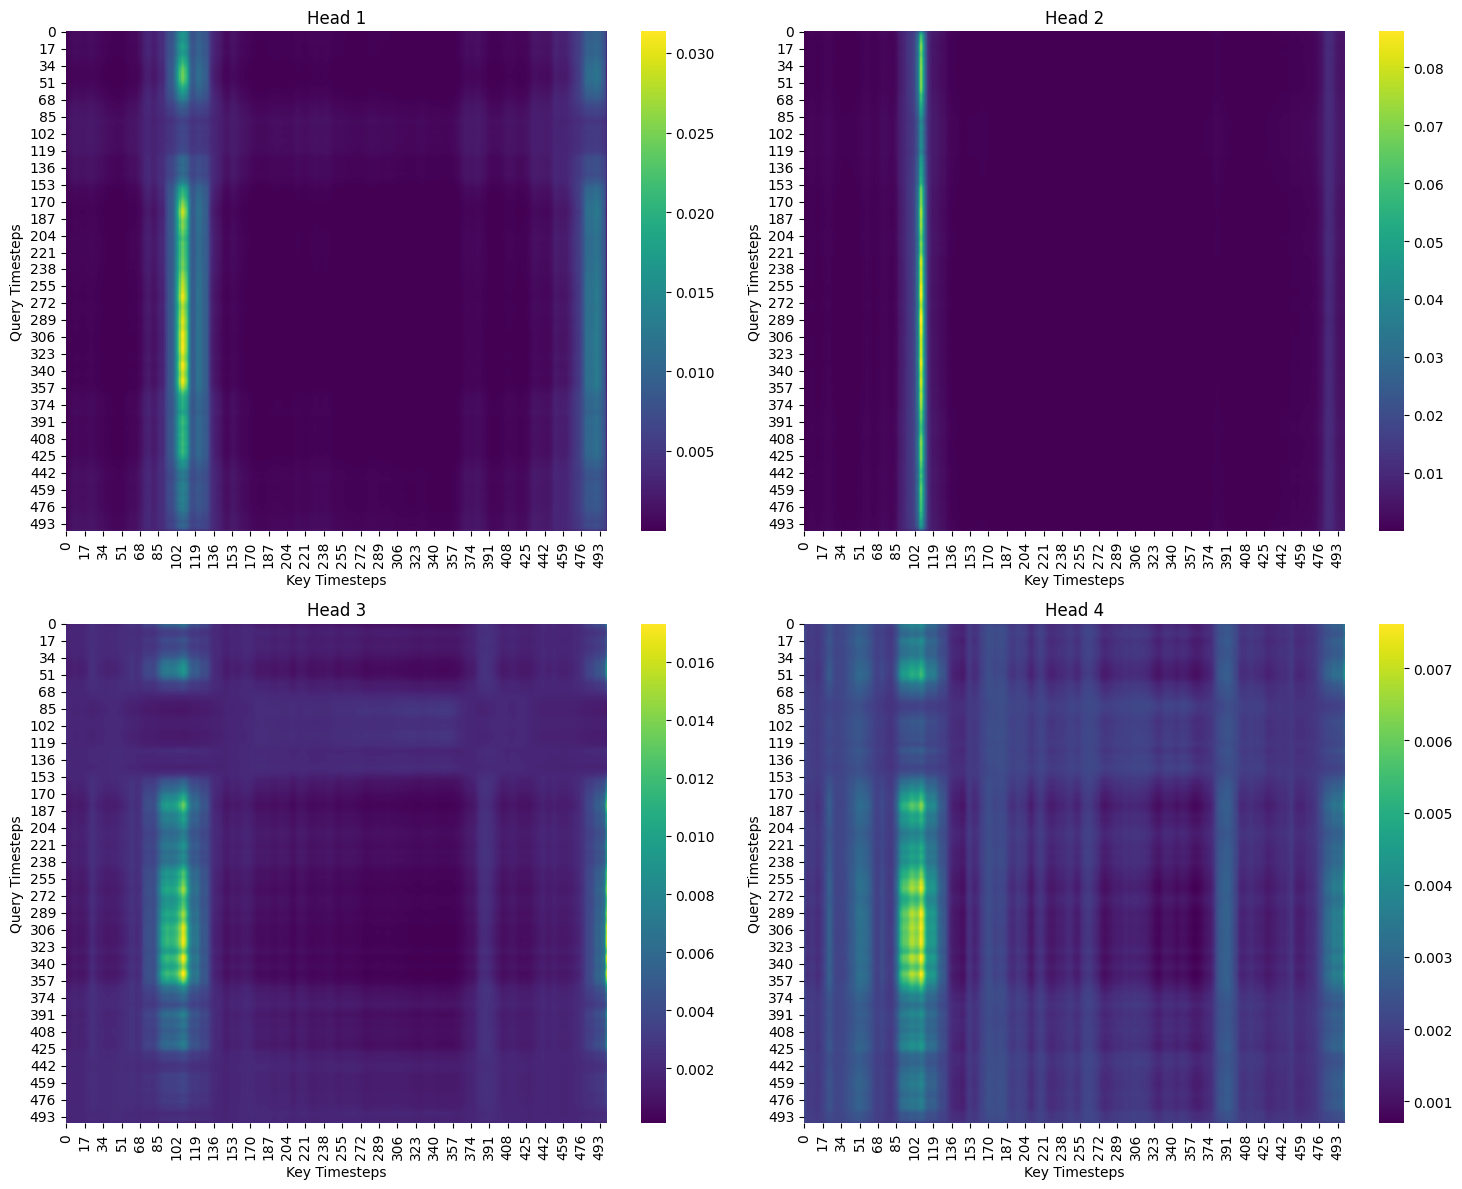

In [ ]:
# Visualize attention heads of the model to see which time steps are important
# Provides interpertability. Brighter regions indicate important time steps
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
for i in range(4):
    ax = axs[i // 2, i % 2]
    sns.heatmap(attention_weights[sample_idx, i, :, :], cmap='viridis', ax=ax)
    ax.set_title(f'Head {i + 1}')
    ax.set_xlabel('Key Timesteps')
    ax.set_ylabel('Query Timesteps')
    
plt.tight_layout()
plt.show()

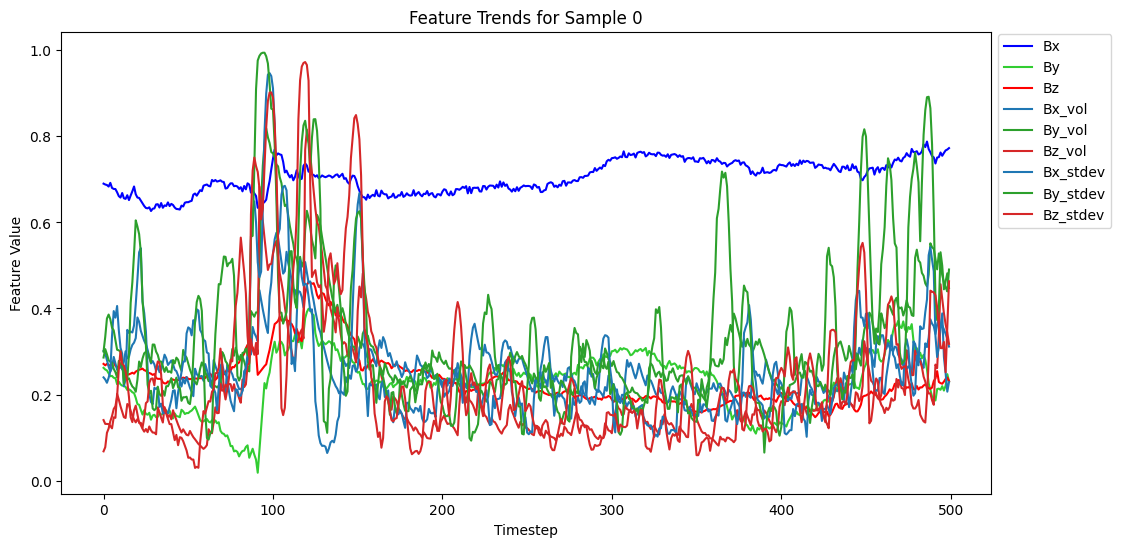

In [ ]:
# Visualize the features in the sample of test set
# Important time steps correspond to high volatility
sample_idx = 0
timesteps = range(X_sample.shape[1])
features_to_plot = [0, 1, 2, 9, 10, 11, 12, 13, 14]
feature_names = ['Bx', 'By', 'Bz', 'Bx_vol', 'By_vol', 'Bz_vol', 'Bx_stdev', 'By_stdev', 'Bz_stdev']
color = ['blue', 'limegreen', 'red', 'C0', 'C2', 'C3', 'C0', 'C2', 'C3']

plt.figure(figsize=(12, 6))
for c, f, fn in zip(color, features_to_plot, feature_names):
    plt.plot(timesteps, X_sample[sample_idx, :, f], color=c, label=fn)

plt.xlabel("Timestep")
plt.ylabel("Feature Value")
plt.title(f"Feature Trends for Sample {sample_idx}")
plt.legend(bbox_to_anchor=(1, 1.01))
plt.show()

In [ ]:
y_pred_probas = np.load("models/mosrl_80_2_customf3_pred_probas.npy")

In [16]:
threshold = 0.5
y_pred = (y_pred_probas >= threshold).astype(int)
y_test = y[test_idx[0]:test_idx[1]]
epoch_test = df.loc[test_idx[0]:test_idx[1], 'Epoch_time']
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84   5424347
           1       0.70      0.86      0.77   3119889

    accuracy                           0.81   8544236
   macro avg       0.80      0.82      0.81   8544236
weighted avg       0.83      0.81      0.81   8544236



In [ ]:
# Create a new dataframe for easier inference
df_compare = df.loc[test_idx[0]:test_idx[1], ['Epoch_time', 'Event_label_80']]
df_compare['Event_pred_probas'] = y_pred_probas
df_compare['Event_pred'] = y_pred

In [ ]:
# Extract the event classes
class_label = pd.read_parquet("data/v80/final_matrix_tha_perp_labeled_v80.parquet")['Event_class'][test_idx[0] + 2:test_idx[1] + 2].values

In [20]:
df_compare['Event_class'] = class_label

In [ ]:
df_compare['Satellite'] = len(df_compare) * ['THEMIS A']

In [ ]:
# Group the event timesteps into event intervals based on the change in class label
df_compare['Class_change'] = (df_compare['Event_class'] != df_compare['Event_class'].shift()).cumsum()
valid_events = df_compare[df_compare['Event_label_80'] == 1]
event_groups = valid_events.groupby(['Class_change', 'Satellite', 'Event_class'])
continuous_sequences = [group.index.tolist() for _, group in event_groups]

In [ ]:
# Iterate through the groups and calculate the ratio of captured event timesteps
# to total event timesteps in each event interval
ratios_by_class = defaultdict(list)
low_ratio_sequences_cls1 = []
low_ratio_sequences_cls2 = []
low_ratio_sequences_cls3 = []

for (_, _, cls), group in event_groups:
    true_label = group['Event_label_80'].values
    pred_label = group['Event_pred'].values

    N_j = np.sum(true_label)
    Nt_j = np.sum(pred_label == 1)

    ratio = Nt_j / N_j if N_j != 0 else np.nan
    ratios_by_class[cls].append(ratio)

    # Identify low ratio sequences and append the indices to respective lists
    if cls == 1 and ratio < 0.4:
        low_ratio_sequences_cls1.append(group.index.tolist())
    if cls == 2 and ratio < 0.4:
        low_ratio_sequences_cls2.append(group.index.tolist())
    if cls == 3 and ratio < 0.4:
        low_ratio_sequences_cls3.append(group.index.tolist())

In [23]:
low_ratio_sequences_all = (low_ratio_sequences_cls1 + low_ratio_sequences_cls2 + low_ratio_sequences_cls3)

event_durations_timesteps = [len(seq) for seq in low_ratio_sequences_all]

avg_duration_timesteps = sum(event_durations_timesteps) / len(event_durations_timesteps)
print(avg_duration_timesteps)

372.09268292682924


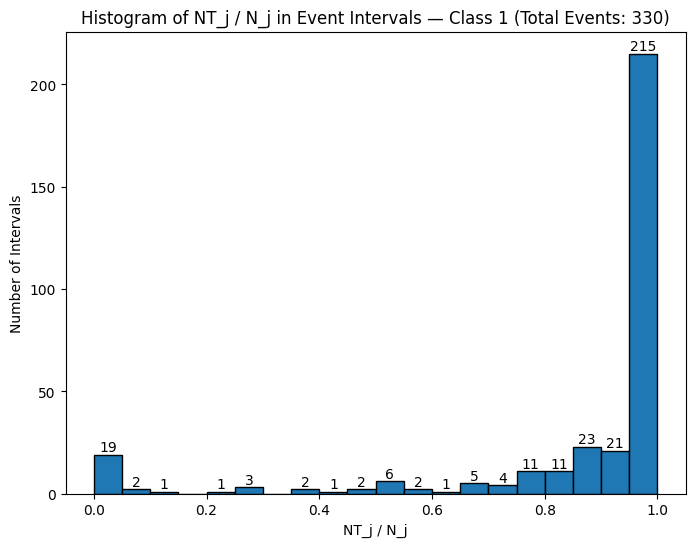

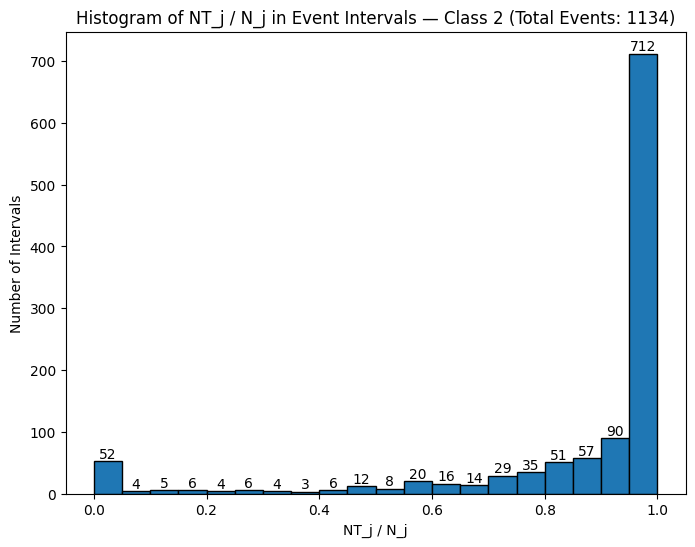

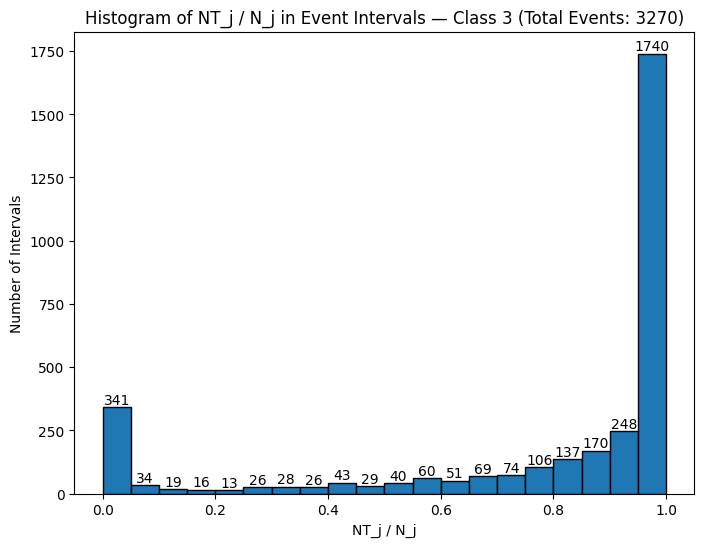

In [ ]:
# Histogram of the captured timesteps and true timesteps in each event interval separated by class
for cls, ratios in sorted(ratios_by_class.items()):
    plt.figure(figsize=(8, 6))
    counts, bins, patches = plt.hist(ratios, edgecolor='black', bins=20)
    for count, bin_edge in zip(counts, bins[:-1]):
        if count > 0:
            plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)),
                     ha='center', va='bottom', fontsize=10)

    plt.xlabel('NT_j / N_j')
    plt.ylabel('Number of Intervals')
    plt.title(f'Histogram of NT_j / N_j in Event Intervals — Class {cls} (Total Events: {len(ratios)})')
    plt.show()

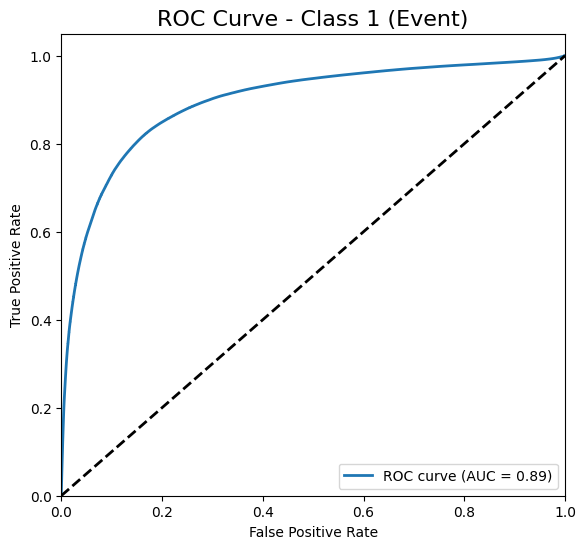

In [27]:
plot_positive_class_roc(y_test, y_pred_probas, dpi=100)

In [ ]:
# Read in necessary files for more information
velocity_test = pd.read_parquet("data/model_data/final_matrix_tha_perp_labeled.parquet")['|V_perp|'][test_idx[0] + 2:test_idx[1] + 2].values
old_idx = pd.read_parquet("data/model_data/final_matrix_tha_perp_labeled.parquet").index.values[test_idx[0]:test_idx[1]]
X_test = X[test_idx[0]:test_idx[1]]
event_df = pd.read_csv('data/event_data_all_perp_80_avg.csv').query("satellite_name == 'THEMIS A'").reset_index(drop=True)

In [ ]:
# Create a dataframe for plotting
df_plot_test = pd.DataFrame({
    "old_index": old_idx,
    "timestamps": epoch_test,
    "y_test": y_test,
    "y_class": class_label,
    "y_pred": y_pred,
    "velocity": velocity_test,
    "Bx": X_test[:, 1],
    "By": X_test[:, 2],
    "Bz": X_test[:, 3],
    "Bx_stdev": X_test[:, 12],
    "By_stdev": X_test[:, 13],
    "Bz_stdev": X_test[:, 14],
    "Bx_vol": X_test[:, 9],
    "By_vol": X_test[:, 10],
    "Bz_vol": X_test[:, 11],
}).reset_index(drop=True)

In [46]:
df_plot_test = df_plot_test.set_index("old_index")

In [ ]:
# Creates false and non event intervals if the difference in timestep > 300 (5 minutes)
low_ratio_sequences = event_analysis(event_groups, ratio_threshold=0.05, side="lower")
high_ratio_sequences = event_analysis(event_groups, ratio_threshold=0.9, side="upper")

false_events = df_compare.query("Event_label_80 == 0 and Event_pred == 1")
false_sequences = false_events.groupby((false_events['Epoch_time'].diff() > 300).cumsum()).apply(lambda x: list(x.index)).values

non_events = df_compare.query("Event_label_80 == 0 and Event_pred == 0")
non_event_sequences = non_events.groupby((non_events['Epoch_time'].diff() > 300).cumsum()).apply(lambda x: list(x.index)).values

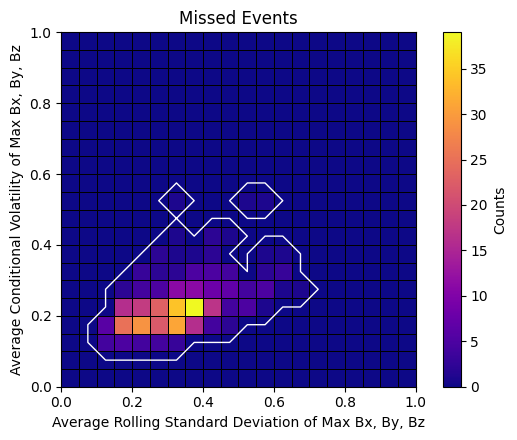

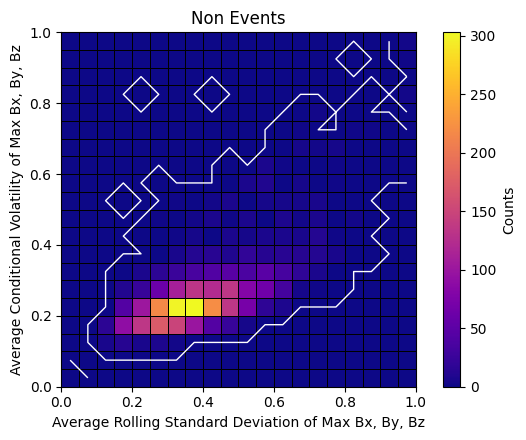

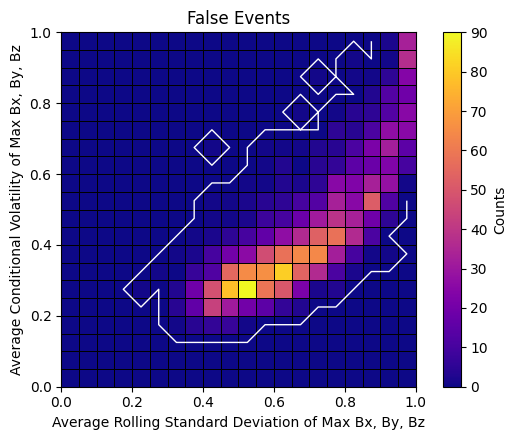

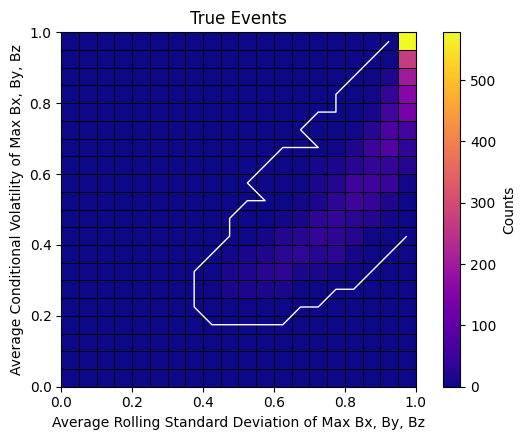

In [ ]:
# 2D histograms to visualize the interactions between the features with last bin removed
plot_vol_stdev_2d_avg_histogram(extract_max_features(low_ratio_sequences, df, True), event_type='Missed', thershold=0.95)
plot_vol_stdev_2d_avg_histogram(extract_max_features(non_event_sequences, df, False), event_type='Non', thershold=0.95)
plot_vol_stdev_2d_avg_histogram(extract_max_features(false_sequences, df, False), event_type='False', thershold=0.95)
plot_vol_stdev_2d_avg_histogram(extract_max_features(high_ratio_sequences, df, True), event_type='True', thershold=0.95)

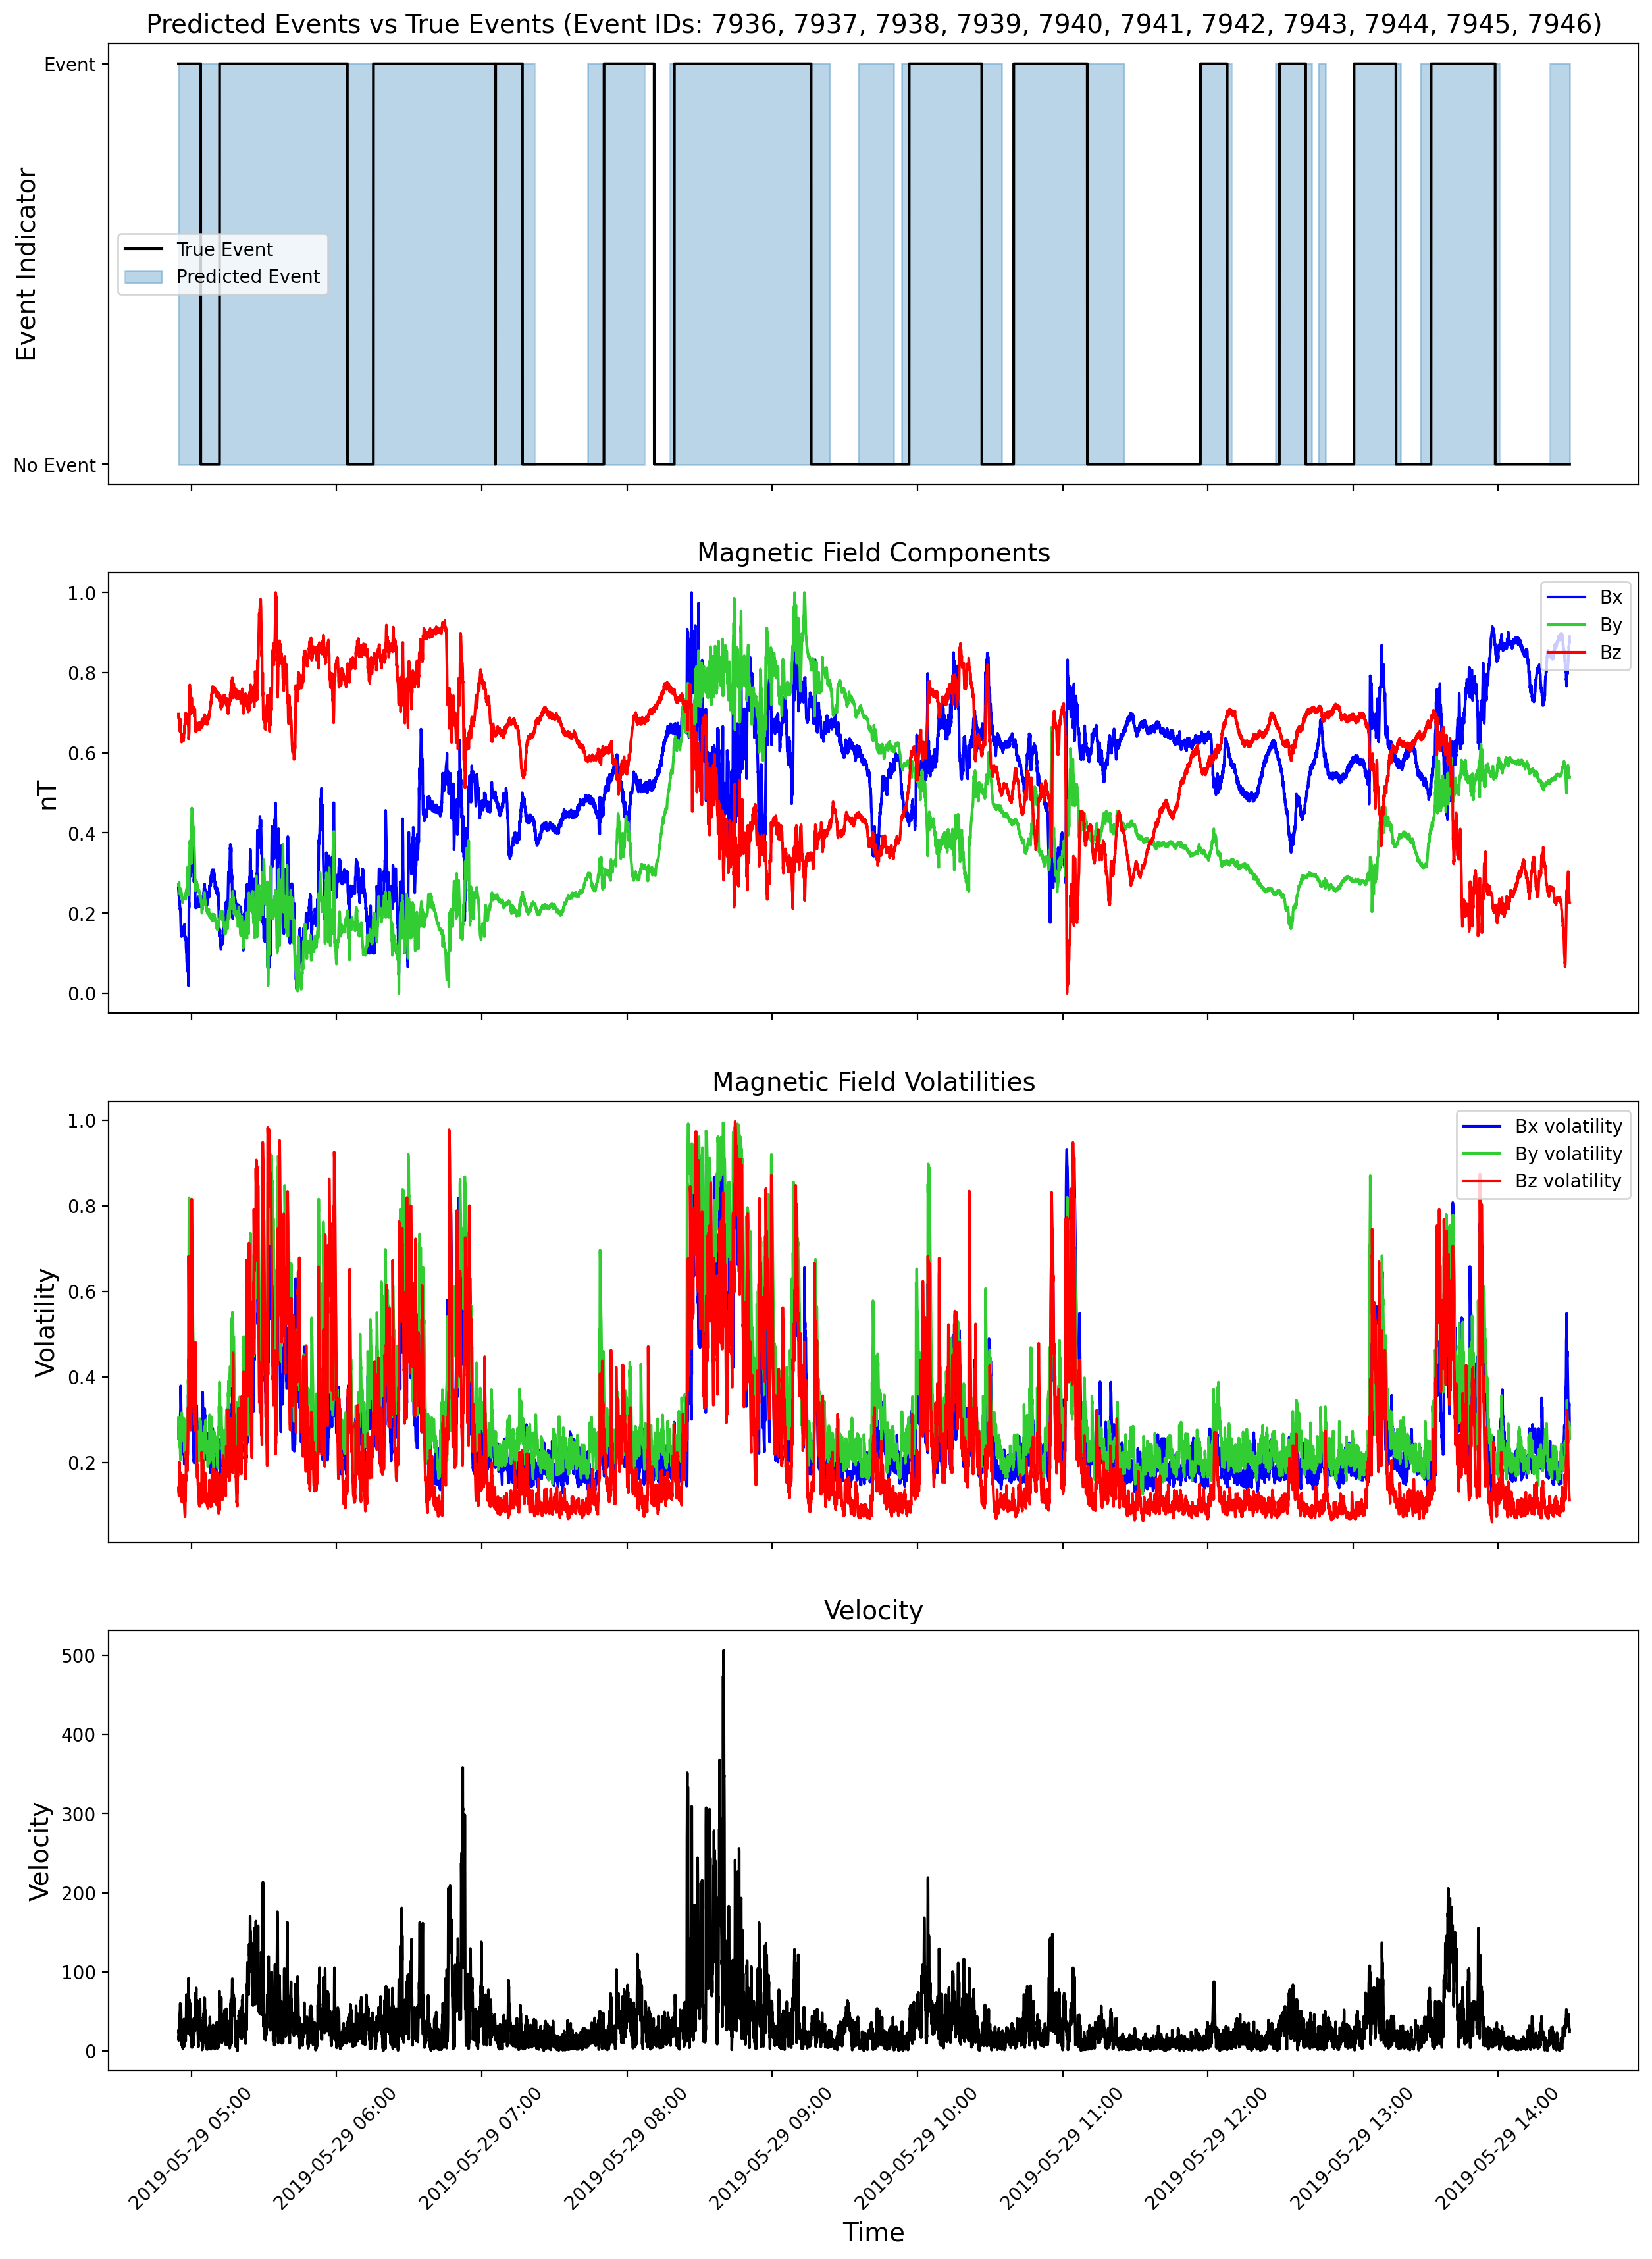

In [32]:
plot_true_vs_pred_all(df_plot_test, event_df, start_idx=0, end_idx=12575, dpi=200)

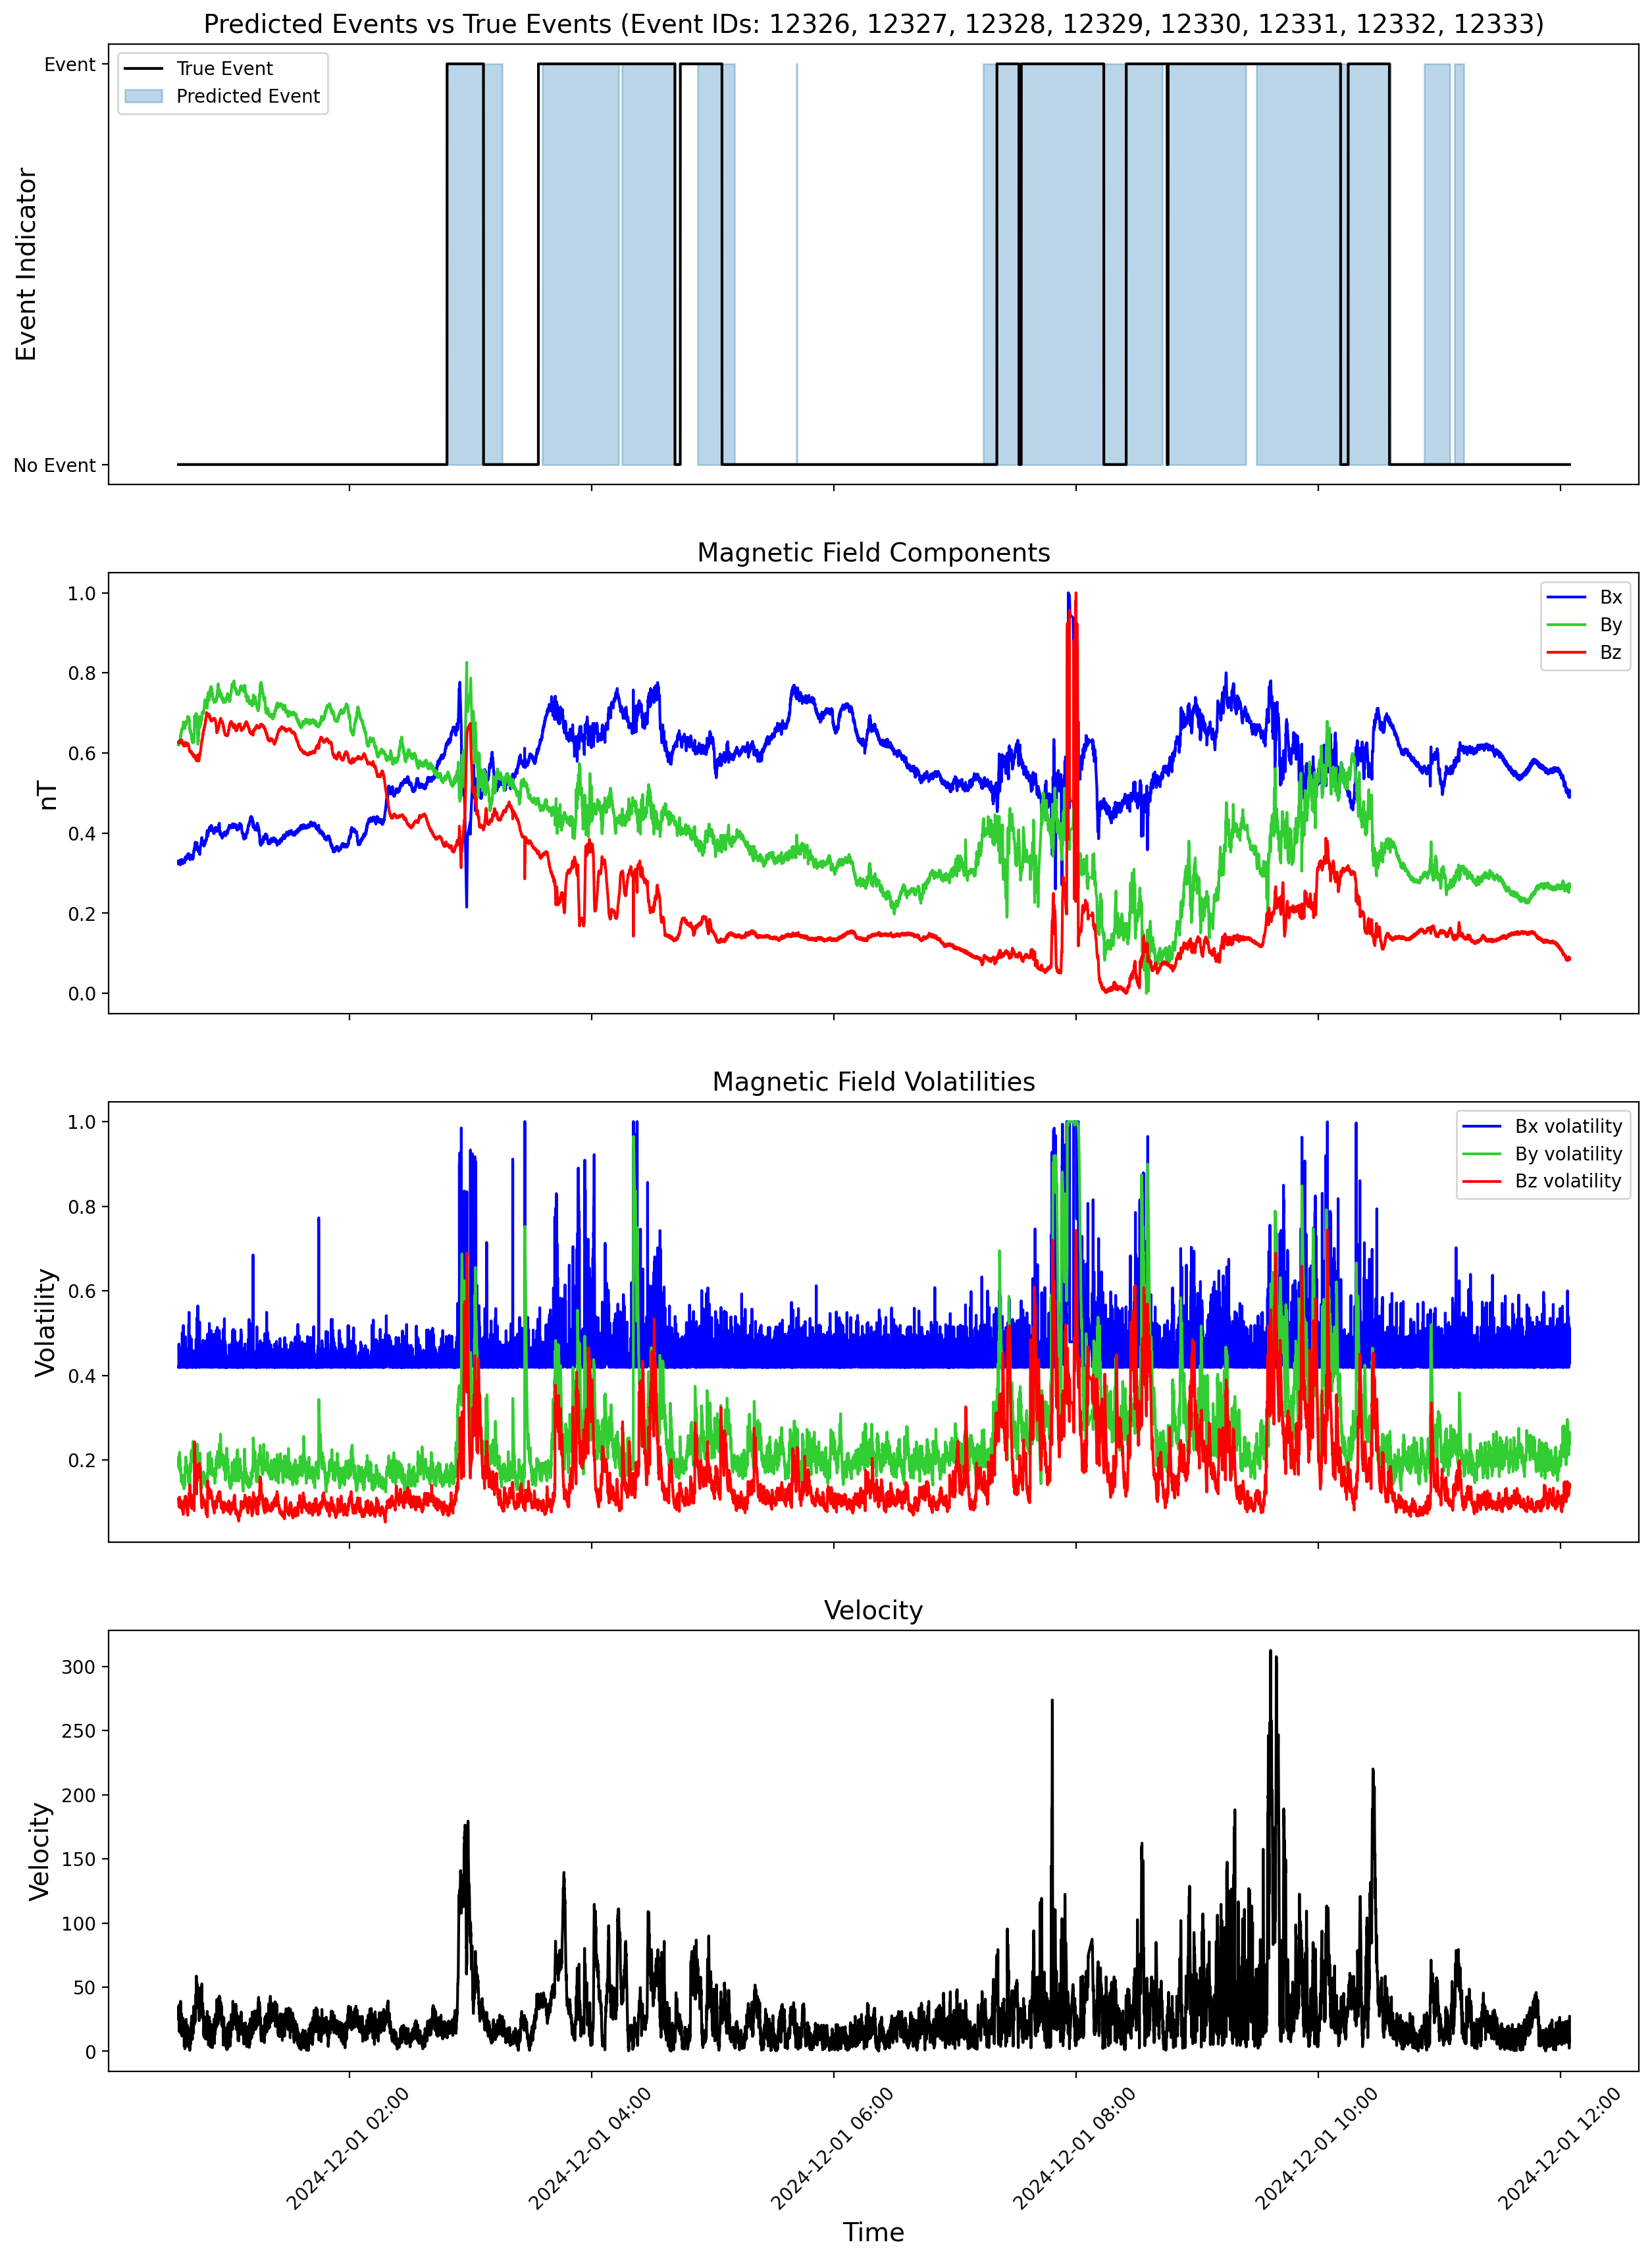

In [33]:
plot_true_vs_pred_all(df_plot_test, event_df, start_idx=7915000, end_idx=7930000, dpi=200)

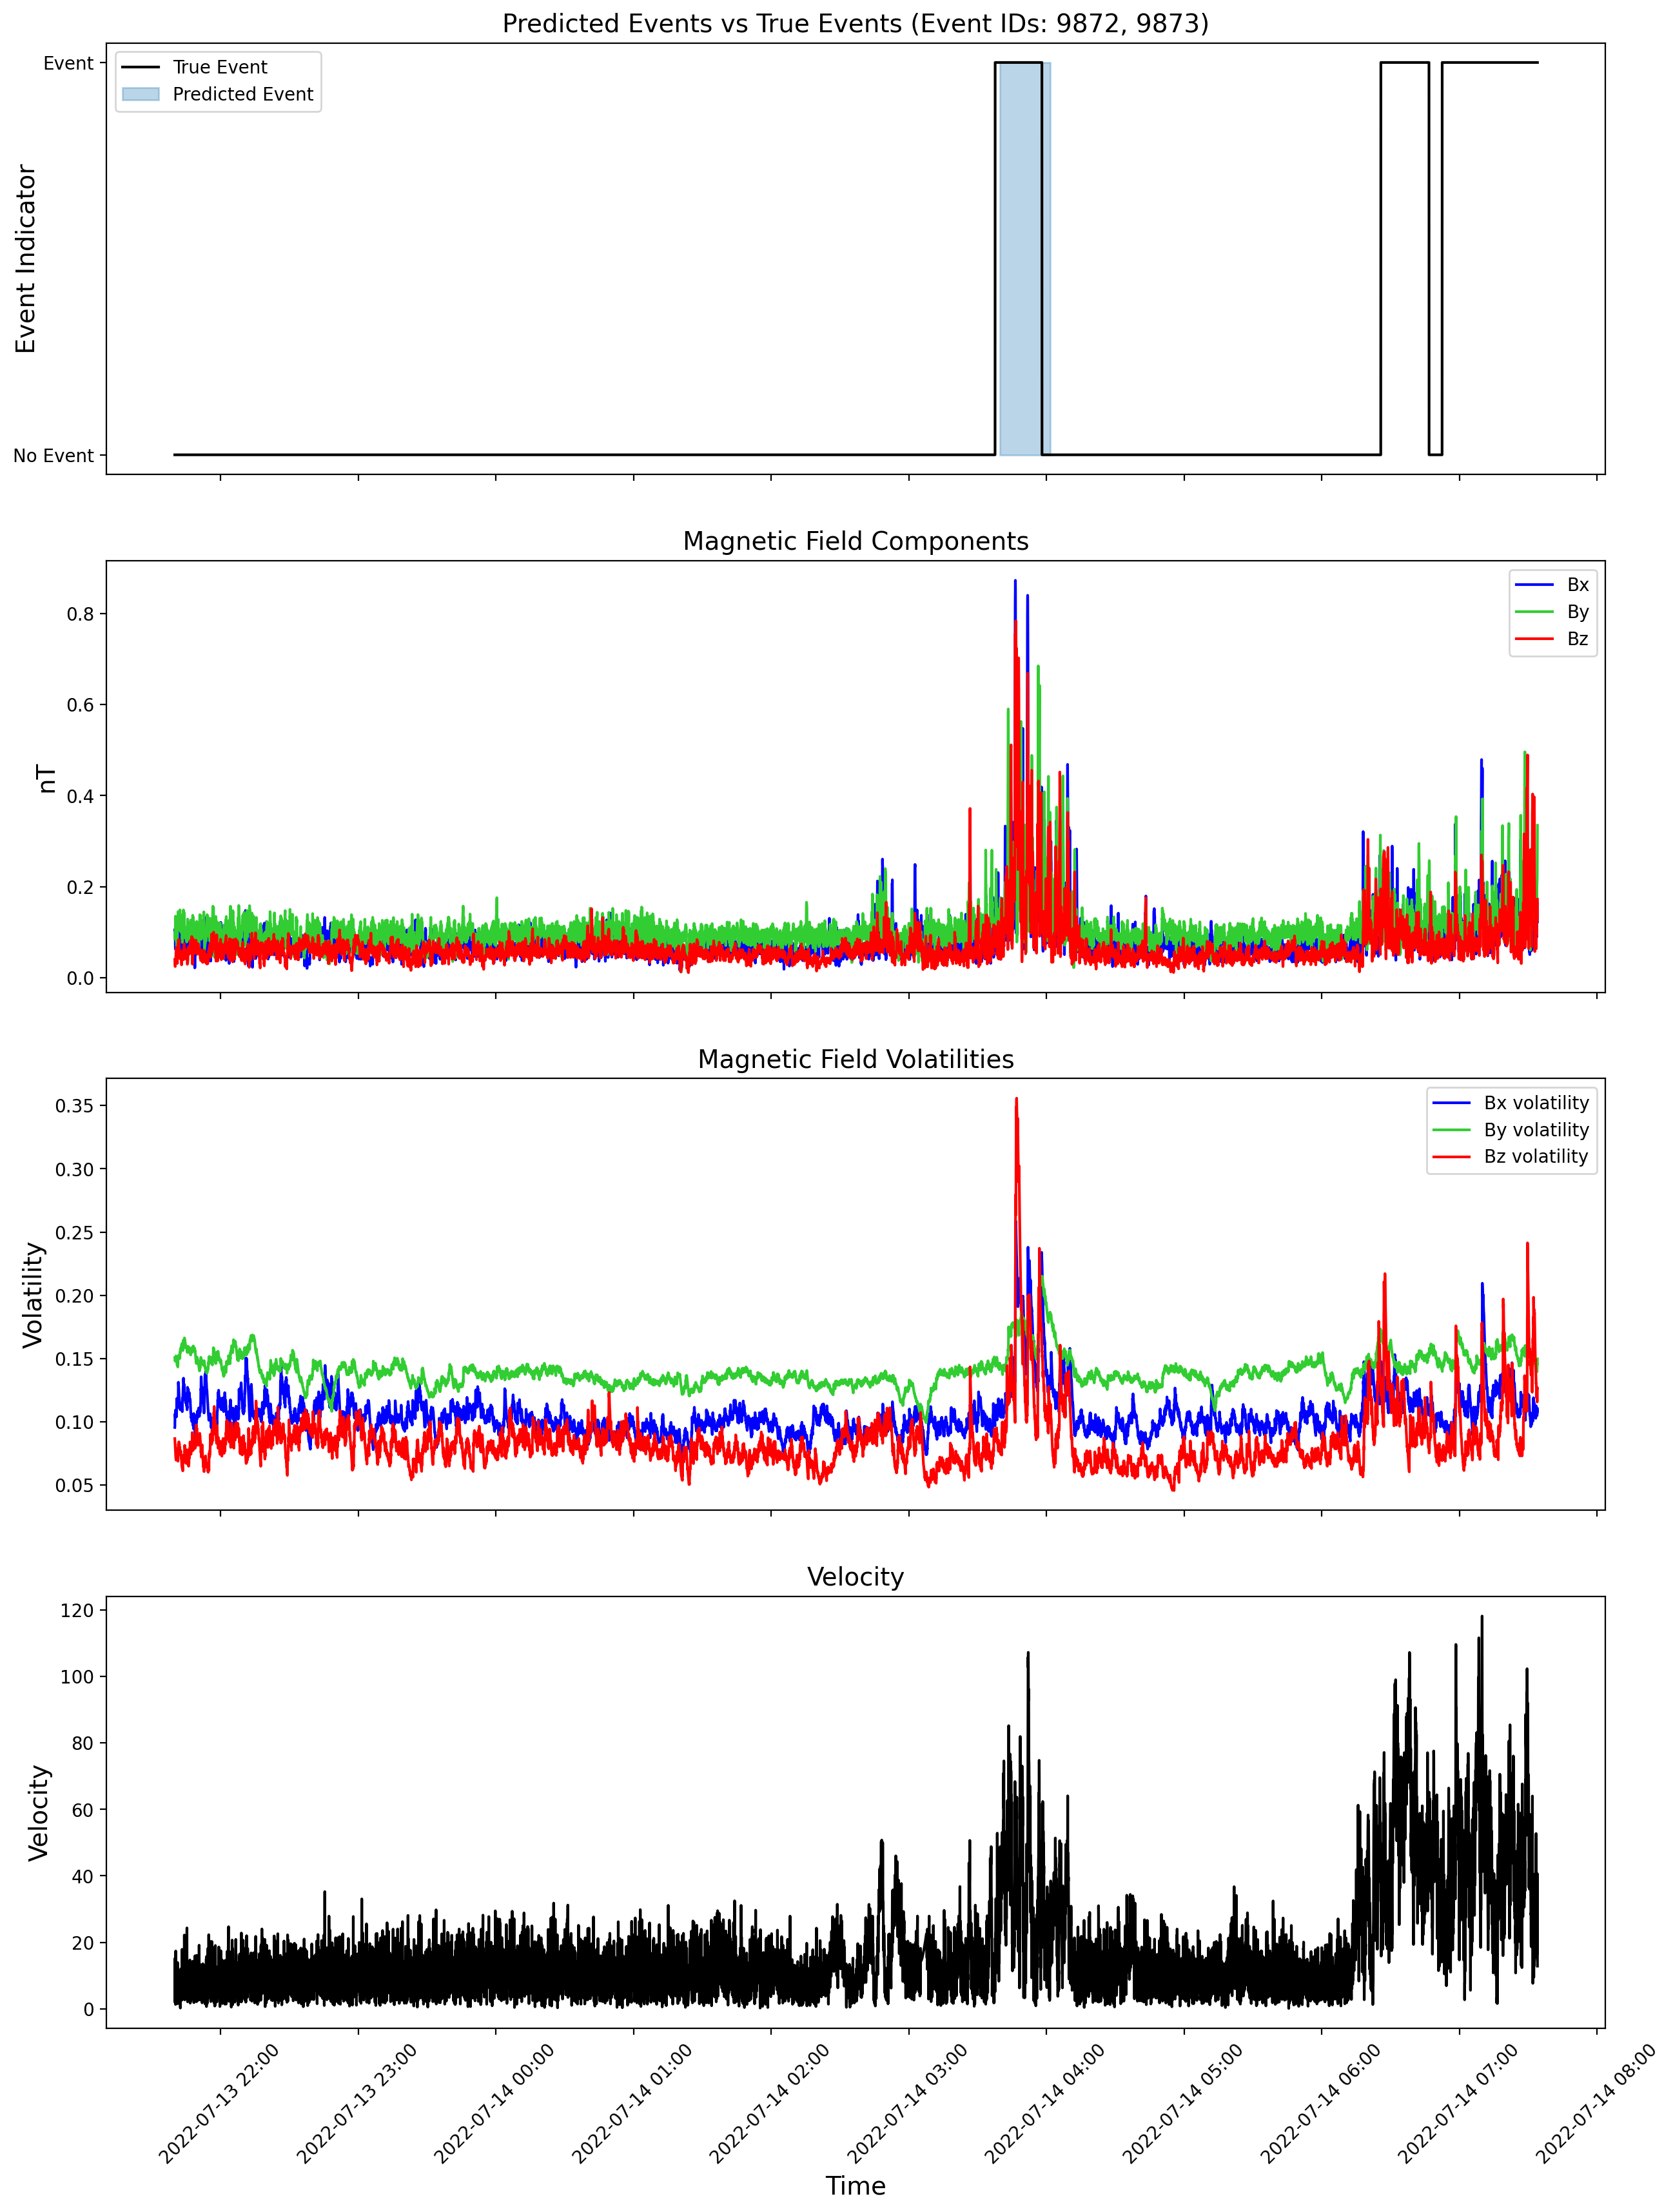

In [48]:
plot_true_vs_pred_all(df_plot_test, event_df, start_idx=3670000, end_idx=3683000, dpi=200)

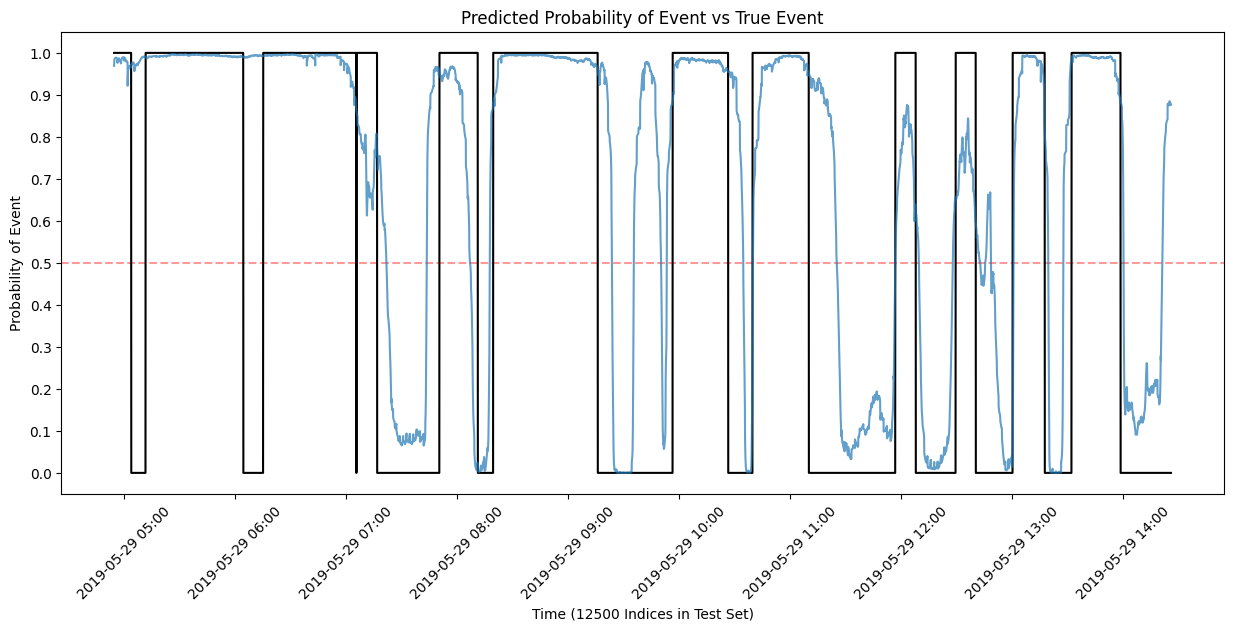

In [38]:
plot_true_vs_pred_probas(y_test, y_pred_probas, epoch_test, threshold, start_idx=0, end_idx=12500, dpi=100)

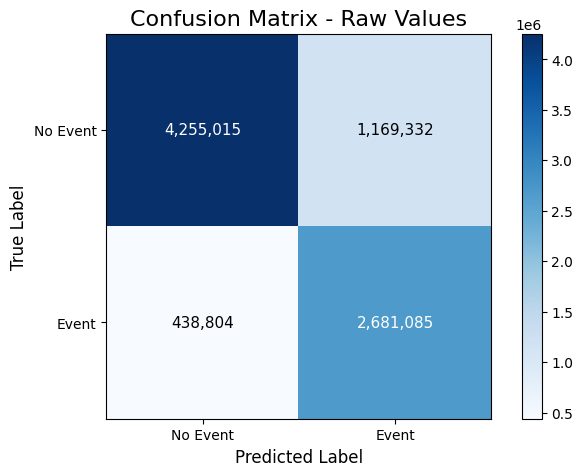

In [36]:
plot_raw_confusion_matrix(y_test, y_pred, dpi=100)